**Partimos del notebook 12**

Pequeño resumen
* Hemos trabajado la arquitectura U-Net, con el objetivo de entrenar el carvan car para extraer mascaras en el standofordCars dataset
* Hemos probador diferentes augmentadores
* Se detecto que entrenava muy bien con el carvana (tanto train como test) muy mal en el Standoford Cars
* Se detecto que posiblemente el problema era que a pesar de las aumentaciones el fondo tanto en el test como en el train del carvan es el mismo fondo, esto hace que la prediccion en el StandFord es muy mala, especialmente con el fondo
* Se decidio añadir un nuevo dataset el "Intel Image Classification" (este dataset tiene imagenes de edificios / streets etc..)
* Decidimos modificar el fondo de las imagenes del carvana, y parece que funciono..

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

['stanford-car-dataset-by-classes-folder', 'manualdraw', '12-tfm-cardrawing-try-merge-background-dat', 'intel-image-classification', 'carvana-image-masking-challenge']


Using TensorFlow backend.


In [2]:
!ls '../input/12-tfm-cardrawing-try-merge-background-dat'

__notebook__.ipynb  __results__.html   custom.css
__output__.json     __results___files  unet-carvana-augmented.hdf5


Leemos el modelos Unet

In [3]:
model_file = '../input/12-tfm-cardrawing-try-merge-background-dat/unet-carvana-augmented.hdf5'
model=load_model(model_file)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
________________________________________________________________________

Hemos entrenado el modelo en el Notebook 12, erpo en el 12 hemos echado un vistazo rapido al Standford cars, intentaremos analizar un poco mas a fondo el comportamento de la unet sobre el StandFord y mirar si podemos detectar cosas

In [4]:


standfordcars_train = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
standfordcars_test = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'

images=[]
for x in os.listdir(standfordcars_train):
    for image in os.listdir(standfordcars_train+'/'+str(x)):
        images.append(standfordcars_train+'/'+str(x)+'/'+image)
        
for x in os.listdir(standfordcars_test):
    for image in os.listdir(standfordcars_test+'/'+str(x)):
        images.append(standfordcars_test+'/'+str(x)+'/'+image)
        
print(len(images))
images[0:5]

16185


['../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/06401.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/03549.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/02122.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/08093.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ferrari California Convertible 2012/07829.jpg']

In [5]:


H = 256
W = 256

def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))

In [6]:

def get_clean_image(img,mask):    
    # img = cv2.imread(path)
    # img = cv2.resize(img, (h, w))
    # print(imshow(img))
    #mask = cv2.imread(maskimage)
    # mask=np.int8((imread(path_mask)))
    # print(mask)   
    # get first masked value (foreground)
    img = np.uint8(img)
    mask = np.uint8(mask)
    fg = cv2.bitwise_or(img, img, mask=mask)
    # get second masked value (background) mask must be inverted
    mask = cv2.bitwise_not(mask)
    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv2.bitwise_or(background, background, mask=mask)

    # combine foreground+background
    final = cv2.bitwise_or(fg, bk)

    return final

In [7]:
import cv2
def get_edge_v2(img):
    blurred = cv2.GaussianBlur(img, (7,7), 0) # Remove noise
    #close the small line gaps using errosion
    kernel = np.ones((5,5), np.uint8)
    erode = cv2.erode(blurred, kernel, iterations = 1)
    #plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=50, threshold2=180) 
    #return np.invert(canny_edges)
    #return np.invert(canny_edges)
    #plt.imshow(canny_edges)

    #close the small line gaps using dilation
    kernel = np.ones((3,3), np.uint8)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = 1)
    return np.invert(dilation_canny)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (3,3), 0) # Remove noise
    #invetimos la mascara queremos el blanco de fondo y el negro como dibujo del coche
    return np.invert(canny_blurred)

In [8]:

def get_img_info(img):
    #plt.imshow(img)
    #print("SHAPE-->", img.shape)
    #plt.show()
    lista=[]
    tmp = downsample(img,H,W)
    img = cv2.cvtColor(np.uint8(tmp), cv2.COLOR_RGB2GRAY).reshape(H,W,1)
    lista.append(img/255)
    lista.append(img/255)
    xpred = model.predict(np.array(lista).reshape(2,H,W,1))
    #plt.imshow(xpred[0].reshape(H,W))
    #plt.show()
    #print(np.max(img))
    final_car = get_clean_image(tmp, ((xpred[0]>0.8)*255))
    edge = get_edge_v2(np.uint8(tmp))
    #plt.imshow(final_car)
    #plt.show()
    return img.reshape(H,W), xpred[0].reshape(H,W), final_car, edge
    

In [9]:
def myplot():
    # original predict mask only_car edges
    rows = 5
    fig,ax=plt.subplots(rows,4,figsize=(13,25))
    for x in range(rows):
        imgpath = randomimg[x]
        img = imread(imgpath)
        resized, mask, end_car, edges = get_img_info(img)
        ax[x,0].imshow(resized)
        ax[x,1].imshow(mask)
        ax[x,2].imshow(end_car)
        ax[x,3].imshow(edges)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


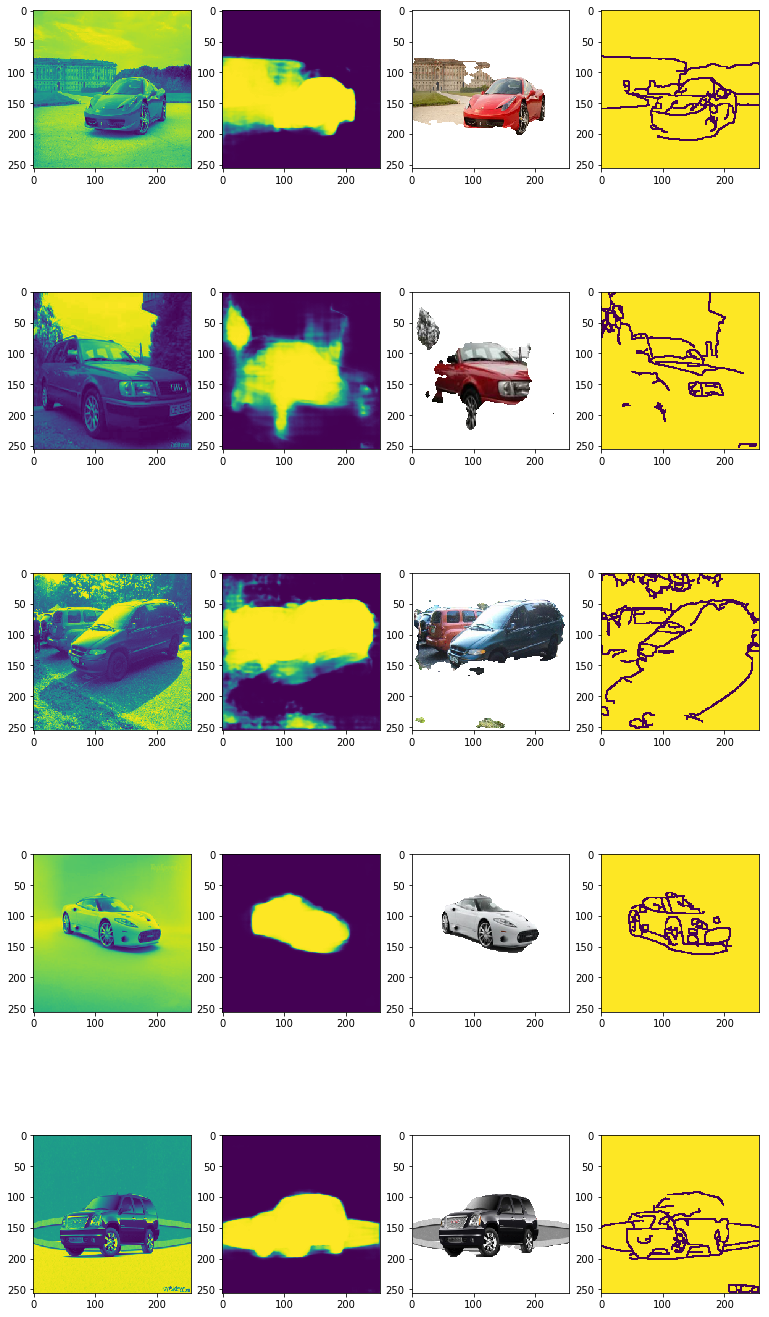

In [10]:
# Vamos a hacer print de unas 10 imagenes random
randomimg = np.random.choice(images,250)
myplot()
#randomimg
#img1 = imread(randomimg[135])
#plot_img_and_info(img1)